# Tabu GRASP

Here we will explore a simple variation to Basic GRASP.  A Tabu List (short term memory) will be added to the construction phase.  If a constructed tour has already been visited there is no value in re-running the local-search.  We therefore discard it and re-run the stochastic semi-greedy construction heuristic of phase 1.



## Imports

In [1]:
import numpy as np
import sys


## `metapy` imports

In [2]:
# install metapy if running in Google Colab
if 'google.colab' in sys.modules:
    !pip install meta-py

In [3]:
from metapy.tsp import tsp_io as io
from metapy.tsp.euclidean import gen_matrix, plot_tour

from metapy.tsp.objective import OptimisedSimpleTSPObjective

from metapy.local_search.hill_climbing import (HillClimber, TweakTwoOpt)

from metapy.tsp.grasp import (SemiGreedyConstructor, 
                              FixedRCLSizer,
                              GRASP)

## Load problem

In [4]:
#load file
file_path = 'https://raw.githubusercontent.com/TomMonks/meta-py/main/data/st70.tsp'

#number of rows in the file that are meta_data
md_rows = 6

#read the coordinates
cities = io.read_coordinates(file_path, md_rows)
matrix = gen_matrix(cities, as_integer=True)

## Implementation

Here we implement a tabu list in the `ConstructorWithMemory` class.  The class accepts a standard constructor such as `SemiGreedyConstructor` and adds a list as the memory.

In [5]:
class ConstructorWithMemory:
    '''
    Provides a construction heuristic with a short term memory
    '''
    def __init__(self, constructor, memory_size=100):
        '''Constructor method
        
        Params:
        -------
        constructor: Object
            Implements build() and returns a solution
            
        memory_size, int, optional (default=100)
            size of tabu list
        '''
        self.constructor = constructor
        self.memory_size = memory_size
        # memory implemented as list
        self.history = []
        
    def build(self):
        '''
        Run the stochastic construction heuristic
        
        Re-runs heuristic if results is within memory
        
        Returns:
        --------
        np.ndarray
        '''
        solution = self.constructor.build()
        while str(solution) in self.history:
            solution = self.constructor.build()
        
        # if at capacity remove oldest solution
        if len(self.history) >= self.memory_size: 
            self.history.pop(0)
        
        self.history.append(str(solution))
        return solution

## Running GRASP with a tabu list

In [6]:
def compose_grasp(max_iter=50, rcl_size=5, memory_size=100, random_seed=None):
    '''
    Compose a GRASP algorithm with a variation to include a TABU list
    in the construction phase.
    '''
    # objective function
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt()

    # local search = first improvement hill climbing
    ls = HillClimber(obj, tour, tweaker)

    # semi-greedy constructor and RCL sizer
    sizer = FixedRCLSizer(r=rcl_size)
    constructor = SemiGreedyConstructor(sizer, tour, -matrix, 
                                        random_seed=random_seed)
    # add memory to constructor
    constructor = ConstructorWithMemory(constructor, memory_size=memory_size)

    # bring ingredients together in the GRASP framework
    solver = GRASP(constructor, ls, max_iter=max_iter)
    
    return solver


Running tabu GRASP

** GRASP OUTPUT ***
best cost:	-724.0
best solutions:
[ 0 35 22 15 46 36 57  4 52  5 40 41 17  3  1  6 31  2 43 67 42 16 59 51
  9 49 50 64 63 10 55 66 47 53 61 32 11 20 33  8 39 60 38 44 24 45 26 29
 19 13 27  7 25 48 54 18 23 14 56 65 21 62 58 37 68 30 12 69 34 28]


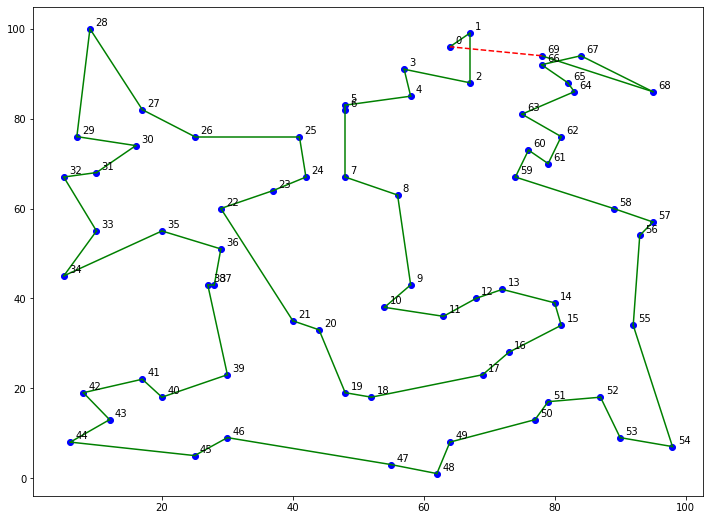

In [7]:
tour = np.arange(len(cities))
solver = compose_grasp(random_seed=101)
print("\nRunning tabu GRASP")
solver.solve()

print("\n** GRASP OUTPUT ***")
print(f'best cost:\t{solver.best}')
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))